In [1]:
!pip install cvxpy
!pip install mosek

     |████████████████████████████████| 9.3 MB 3.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [3]:
import pandas as pd
import cvxpy as cp
import mosek
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
import random
from scipy.integrate import cumtrapz

mpl.rcParams['figure.dpi'] = 200

# TODO

1. Ideal ICE model
2. Dynamic drag based on vehicle interval
3. More complete parameter study with paired parameter study
4. Misc based on Prof. feed back

# Model

## Assumptions

1. flat surface,
2. pre-timed signals,
3. vehicle platoon with previous knowledge of the signal timings,
4. vehicle enter the corridor with 0 velocity,
5. constant air density and neglect wind pressure,
6. 

## Constants

In [4]:
# powertrain constant to define

## Shared across platforms

m = 1611+82             # average vehicle mass + driver [kg]
rho = 1.225             # air density [kg/m^3]
Cd = 0.23               # drag coefficient
Aref = 2.22             # average vehicle frontal area [m^2]
g = 9.81                # gravity constant [m/s^2]
Crr = 0.01              # rolling resistance coefficient
Cv = 0.3                # kinetic friction coefficient
r = 0.334               # wheel radius [m] (235/45R18 tire)

## ICE only (Honda Civic 2012 5AT)
f_ice = 0.375           # idle fuel consumption [ml/s]
P_max = 104.398         # max engine power [kw]
P_min = 0               # min engine power [kw]
wp_min = 800            # min angular speed of engine at max power [rpm]
wp_max = 6500           # max angular speed of engine at max power [rpm]
wt_max = 4300           # max angular speed of engine at max torque [rpm]
gear = [2.666, 1.534, 1.022, 0.721, 0.525, 4.44] # gear ratio
cor_v = [7.5, 11.4, 16, 22] # corresponding velocity for each gear(ex: gear 1 ratio = 2.666,cor_v = 0~7.5)[m/s]

## EV only
# f_ev =                # idle energy consumption[kW]
capacity_kWh = 54       # [kWh]
Voc = 360               # [V]
Pmax_kW = 211           # [kW]
Tmax_Nm = 375           # [Nm]
Tmax_rpm = Pmax_kW*1000/Tmax_Nm*60/2/np.pi # [rpm] max motor speed at max torque
gear_ratio = 9          # motor to driven axle gear ratio
max_speed = 16000       # [rpm] maximum motor speed
dt_eff = 0.85           # drivetrain efficiency
Rcirc = 0.05            # [Ohms]
full_range = 300        # full range of the EV 

In [16]:
# constraint constants to define

pos_final = 4000        # corridor horizon [m]
N = 380                 # time horizon [sec]
vel_lower = 0           # velocity lower bound [m/s]
vel_upper = 17.5        # velocity upper bound [m/s]
acc_abs = 1.5           # accel upper bound [m/s^2]
jerk_abs = 1            # jerk (derivative of acceleration) upper bound [m/s^3]
lin_drag = 10           # linearize drag about this speed

In [6]:
# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]

N = 380 # minimum time is N~=pos_final/10*0.9
dt = 1
M = 1e5

In [7]:
# Plotting Constants

legend_font = 8

# Single Vehicle Optimization Formulation

## 1. Optimization of one vehicle trajectory through pre-timed signalized intersections

x(t) = [s(t), v(t)], states: position and velocity \\
u(t) = [a(t)], control param: vehicle acceleration 

###**EV Powertrain**

In [17]:
x1 = cp.Variable(N+1) # Position
x2 = cp.Variable(N+1) # Velocity
T = cp.Variable(N) # Powertrain torque
Fdrag = cp.Variable(N) # Vehicle drag
E = cp.Variable(N+1) # Battery energy
Pmot = cp.Variable(N) # Battery power
Vcirc = cp.Variable(N) # Circuit voltage
I = cp.Variable(N) # Motor current
SOC = cp.Variable(N+1) # Battery SOC
pedal = cp.Variable(N, boolean=True)

# Define objective function
objective = cp.Minimize( E[0]-E[N] ); title = 'Minimum Energy' # Minimum energy
# objective = cp.Minimize(-x1@np.ones(N+1) + (E[0]-E[N])); title = 'Minimum Time' # Minimum time - Lower N until solver fails for guaranteed minimum time

# Define constraints
constraints = [ ]
# pos_init = 0 m
constraints += [ x1[0] == 0 ]
# pos_final = 1000 m
constraints += [ x1[N] == pos_final ]
# vel_init = 0 m/s
constraints += [ x2[0] == 0 ]
# vel_final = 0 m/s
constraints += [ x2[N] == 0 ]
# # acc_init = 0 m/s^2
constraints += [ x2[1] == x2[0] ]
# # acc_final = 0 m/s^2
constraints += [ x2[N] == x2[N-1] ]
# Traffic light constraints
# Define a traffic light as [initial time, final time, position]

tls = []
redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection])

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used
# The for loop below will automatically create constraints for all traffic lights
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N and tls_on:            
        dict_index = "tl{0}".format(i)
        tls_bools[dict_index] = cp.Variable(1, boolean=True)
        # Clip end of traffic light if it goes past optimization horizon
        t_initial = int(tls[i][0]/dt)
        if int(tls[i][1]/dt) > N:
            t_final = N
        else:
            t_final = int(tls[i][1]/dt)
        position = tls[i][2]
        constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
        constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

for k in range(0,N):
    # vel_lower >= 0 m/s
    constraints += [ x2[k+1] >= vel_lower ]
    # vel_lower <= 15 m/s (~55 km/hr)
    constraints += [ x2[k+1] <= vel_upper ]
    # acc_lower >= -3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ]
    # acc_upper <= 3 m/s^2
    constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ]
    constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
    constraints += [ x2[k+1] == x2[k] + ( (T[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
    constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2[k]**2 + Cv*x2[k] + Crr*m*g*pedal[k] ]
    constraints += [ E[k+1] == E[k] - Voc*Vcirc[k]/Rcirc*dt/3600 ]
    constraints += [ x2[k]*60/(2*np.pi*r)*gear_ratio <= max_speed ]
    constraints += [ T[k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed + (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
    constraints += [ T[k] >= - Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
    constraints += [ x1[k] >= (pos_final)*(1-pedal[k]) ]

# SOC
constraints += [ SOC[0] == 0.8 ]
constraints += [ SOC == E/capacity_kWh/1000]
constraints += [ SOC <= 0.8 ]
constraints += [ SOC >= 0.2 ]
# Power
constraints += [ Pmot <= Vcirc/Rcirc*Voc - (Vcirc)**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
constraints += [ T <= Tmax_Nm ]
constraints += [ T >= -Tmax_Nm ]
constraints += [ T == Pmot/(Pmax_kW*1000)*Tmax_Nm ]
# Voc
constraints += [ Vcirc/Rcirc <= (Pmax_kW*1000)/Voc ] # Current limit

for k in range(1, N):
    # Minimize jerk (derivative of acceleration)
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
    constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]

In [18]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver='MOSEK')
print(prob.status)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 10818           
  Cones                  : 760             
  Scalar variables       : 6549            
  Matrix variables       : 0               
  Integer variables      : 465             

Optimizer started.
Mixed integer optimizer started.
Threads used: 1
Presolve started.
Presolve terminated. Time = 0.13
Presolved problem: 3834 variables, 3456 constraints, 9594 non-zeros
Presolved problem: 0 general integer, 47 binary, 3787 continuous
Clique table size: 4
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        2        1        0        NA                   5.0632544940e+02     NA          0.8   
0        2        1        0        5.1613799246e+02     5.0632544940e+02     1.90        1.6   
Cut generation started.
0        2        1        0   

===== Minimum Energy =====
Min SOC = 0.78734
Final SOC = 0.79046
Recovered SOC = 0.0063844
Estimated Range = 260.6 miles
Time of Travel = 338 seconds
Max Torque = 75.10 Nm
Max Power = 42.25 kW
Max Motor Speed = 4503 RPM
Max Vel = 17.5 m/s
Max Acc = 0.889 m/s^2
Max Jerk = 1.0 m/s^3


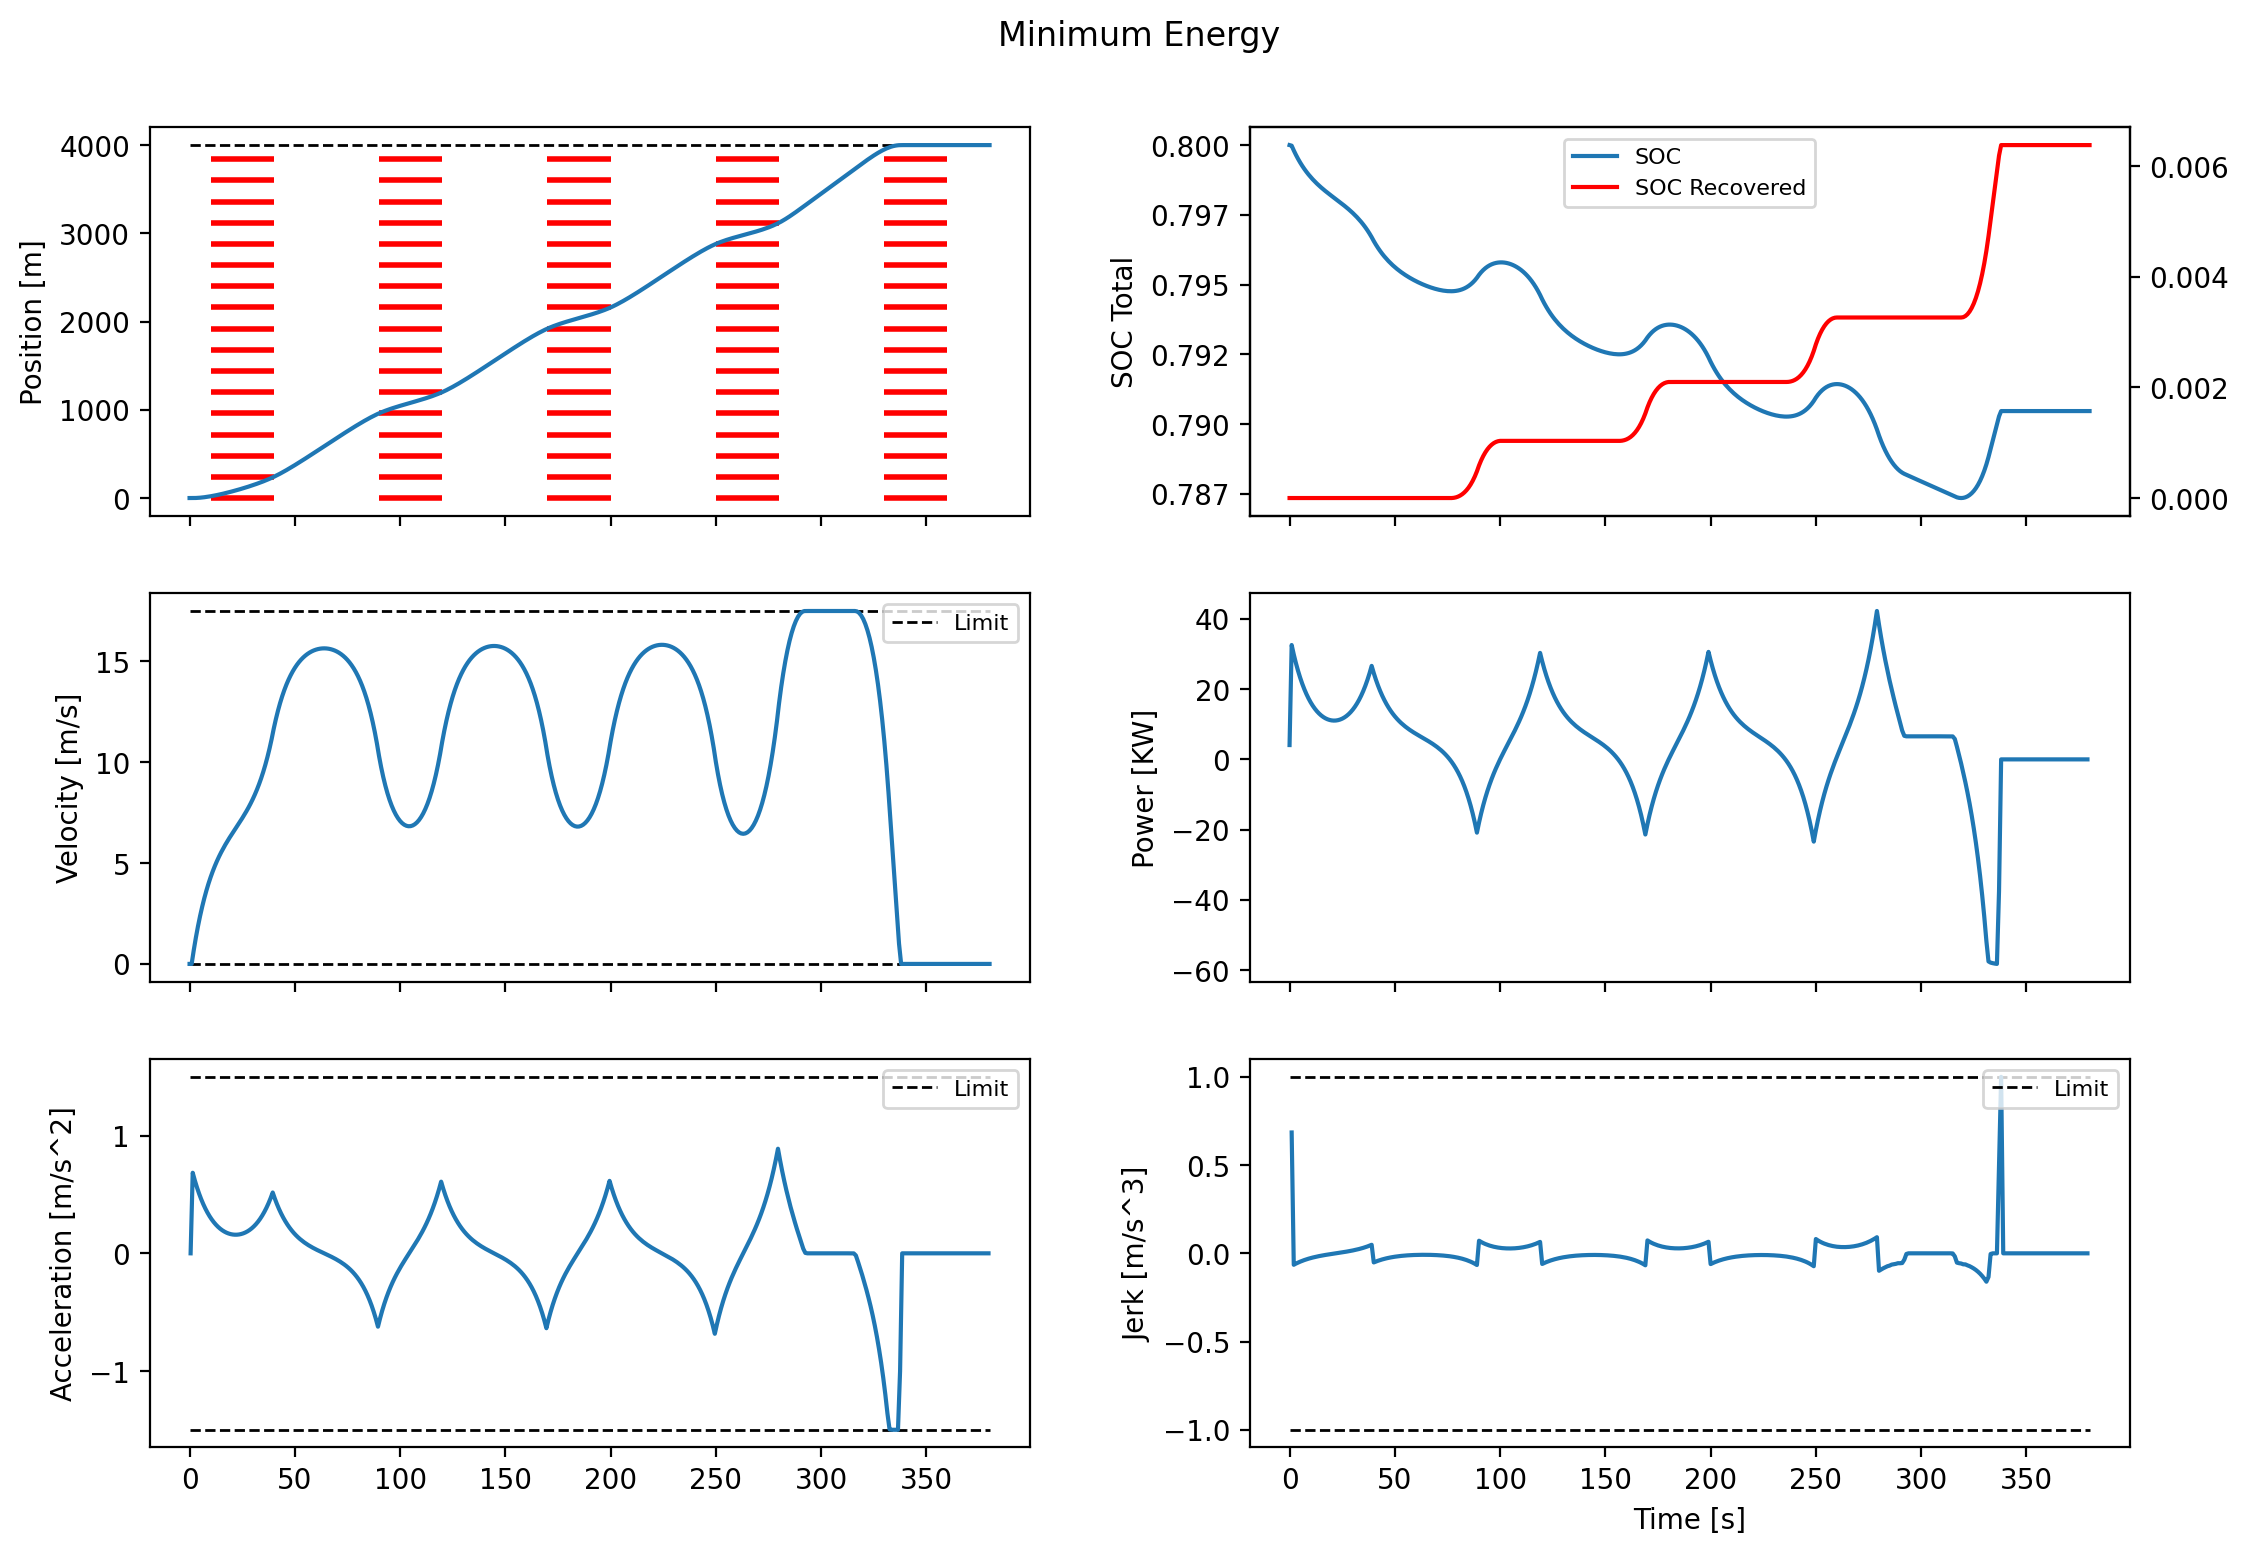

In [19]:
# Calculate recovered energy
E_regen = np.zeros(N+1)
for i in range(1,len(E_regen)):
    if Vcirc.value[i-1] < 0:
        E_regen[i] = E_regen[i-1] - Voc*Vcirc.value[i-1]/Rcirc*dt/3600
    else:
        E_regen[i] = E_regen[i-1]

print(f"======{'='*len(title)}======")
print(f"===== {title} =====")
print(f"======{'='*len(title)}======")
print(f"Min SOC = {np.min(SOC.value):.5}")
print(f"Final SOC = {(SOC.value[-1]):.5}")
print(f"Recovered SOC = {E_regen[-1]/(capacity_kWh*1000):.5}")
print(f"Estimated Range = {1/(SOC.value[0]-SOC.value[-1])*pos_final/1609.34:.5} miles")
print(f"Time of Travel = {np.where(x1.value>=pos_final-0.00001)[0][0]*dt:.0f} seconds")
print(f"Max Torque = {np.max(T.value):.2f} Nm")
print(f"Max Power = {np.max(Pmot.value)/1000:.2f} kW")
print(f"Max Motor Speed = {np.max(x2.value*60/(2*np.pi*r)*gear_ratio):.0f} RPM")
print(f"Max Vel = {np.max((x2.value)):.4} m/s")
print(f"Max Acc = {np.max((x2.value[1:]-x2.value[:-1])/dt):.4} m/s^2")
print(f"Max Jerk = {np.max((x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2):.4} m/s^3")

time = np.arange(0, (N+1)*dt, dt)
fig, axs = plt.subplots(3,2, figsize=(12,8), sharex=True)
axs = axs.flatten()
fig.suptitle(title)
# Plot order
plt_pos = 0
plt_vel = 2
plt_acc = 4
plt_jerk = 5
plt_power = 3
plt_soc = 1
axs[plt_pos].plot(time, x1.value)
axs[plt_pos].set_ylabel('Position [m]')
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[plt_pos].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2.value[1:]-x2.value[:-1])/dt)
axs[plt_acc].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_acc].legend(loc='upper right', fontsize=legend_font)
axs[plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[plt_vel].plot(time, x2.value)
axs[plt_vel].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_vel].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_vel].legend(loc='upper right', fontsize=legend_font)
axs[plt_vel].set_ylabel('Velocity [m/s]')
axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2)
axs[plt_jerk].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_jerk].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_jerk].legend(loc='upper right', fontsize=legend_font)
axs[plt_jerk].set_ylabel('Jerk [m/s^3]')
axs[plt_power].plot(time[:-1], Pmot.value/1000)
axs[plt_power].set_ylabel('Power [KW]')
axs[plt_soc].plot(time, SOC.value, label='SOC')
axs[plt_soc].set_ylabel('SOC Total')
axs[plt_soc].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.3f}'))
axstwinsoc = axs[plt_soc].twinx()
axstwinsoc.plot(time, E_regen/(capacity_kWh*1000), 'r', label='SOC Recovered')
h1, l1 = axs[plt_soc].get_legend_handles_labels()
h2, l2 = axstwinsoc.get_legend_handles_labels()
axs[plt_soc].legend(h1+h2, l1+l2, loc='upper center', fontsize=legend_font)
axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

### **ICV Powertrain**

#### **Assumptions**
The parameters used in the model is from 2012 Honda Civic 1.8 5AT. 

Engine Model based on 'Ni and Henclewood (2008)'
 $$P_{e} = \sum_{i=1}^{3}C_{i}*{w^i_{e}}$$

Gear Model based on 'Wong, Theory of Ground Vehicles., 3rd ed', and 'Ni and Henclewood (2008)'

Torque converter model is ignored

In the gear model, assume the gear is changing based on the velocity, and acheive the 5th gear when the velocity is greater or equal to 80 km/hr (~22 m/sec). In addition, assume that the max velocity at each gear multiply with overall reduction ratio (ie, gear ratio multiply final gear ratio) is the same.

##### **ex**
For the 5th gear, the min velocity is 22 m/sec, gear ratio is 0.525, final gear ratio is 4.44, 

22 x 0.525 x 4.44 = 51.282

For 4th gear, the gear ratio is 0.721, the max speed at this gear is: v = 51.282/0.721/4.44 = 16 [m/sec] 

In [30]:
# Use EV drive cycle to determine gear selection
gears = []
for speed in x2.value:
    if speed <= cor_v[0]:
        gears.append(1)
    elif speed > cor_v[0] and speed <= cor_v[1]:
        gears.append(2)
    elif speed > cor_v[1] and speed <= cor_v[2]:
        gears.append(3)
    elif speed > cor_v[2] and speed <= cor_v[3]:
        gears.append(4)
    elif speed > cor_v[3]:
        gears.append(5)

# Assumptions:

# Solve with CVXPY

# Define optimization vars
x1_ICE = cp.Variable(N+1) # Position
x2_ICE = cp.Variable(N+1) # Velocity
Fdrag = cp.Variable(N) # Vehicle drag
Pe = cp.Variable(N) # Power of engine
we = cp.Variable(N) # Angular speed of engine
pedal = cp.Variable(N, boolean = True)

# Define objective function
objective = cp.Minimize( sum(Pe) ); title = 'Minimum Energy' # Minimum energy

# Define constraints
constraints = [ ]
# pos_init = 0 m
constraints += [ x1_ICE[0] == 0 ]
# pos_final = 1000 m
constraints += [ x1_ICE[N] == pos_final ]
# vel_init = 0 m/s
constraints += [ x2_ICE[0] == 0 ]
# vel_final = 0 m/s
constraints += [ x2_ICE[N] == 0 ]
# # acc_init = 0 m/s^2
constraints += [ x2_ICE[1] == x2_ICE[0] ]
# # acc_final = 0 m/s^2
constraints += [ x2_ICE[N] == x2_ICE[N-1] ]

# Traffic light constraints
# Define a traffic light as [initial time, final time, position]
tls = []
redlight = 30 # redlight duration [sec]
greenlight = 50 # greenlight duration [sec]
block = 240 # length of one block [m]
for intersection in np.arange(0, pos_final, block):
    for start in np.arange(10, N*dt, redlight + greenlight):
        tls.append([start, start + redlight, intersection])

tls_bools = {}
tls_on = True # Control whether or not traffic lights are used

# The for loop below will automatically create constraints for all traffic lights
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][0]/dt) <= N and tls_on:            
        dict_index = "tl{0}".format(i)
        tls_bools[dict_index] = cp.Variable(1, boolean=True)
        # Clip end of traffic light if it goes past optimization horizon
        t_initial = int(tls[i][0]/dt)
        if int(tls[i][1]/dt) > N:
            t_final = N
        else:
            t_final = int(tls[i][1]/dt)
        position = tls[i][2]
        constraints += [ x1_ICE[t_final]   - position <=  M*tls_bools[dict_index] ]
        constraints += [ x1_ICE[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

for k in range(0,N):
    # vel_lower >= 0 m/s
    constraints += [ x2_ICE[k+1] >= vel_lower ]
    # vel_lower <= 15 m/s (~55 km/hr)
    constraints += [ x2_ICE[k+1] <= vel_upper ]
    # acc_lower >= -3 m/s^2
    constraints += [ (x2_ICE[k+1] - x2_ICE[k])/dt >= -acc_abs ]
    # acc_upper <= 3 m/s^2
    constraints += [ (x2_ICE[k+1] - x2_ICE[k])/dt <= acc_abs ]
    constraints += [ x1_ICE[k+1] == x1_ICE[k] + x2_ICE[k]*dt ]
    constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2_ICE[k]**2 + Cv*x2_ICE[k] + Crr*m*g * pedal[k] ]
    constraints += [ x1_ICE[k] >= (pos_final)*(1-pedal[k]) ]
    
    # Engine Model
    constraints += [ Pe[k] >= P_max/wp_max * we[k] + P_max/wp_max**2 * we[k]**2 - P_max/wp_max**3 * 1500**3]
    constraints += [ x2_ICE[k] == we[k]*r*(2*np.pi/60)/(gear[gears[k]-1]*gear[5]) - Fdrag[k]/m*dt]
    
for k in range(1, N):
    # Minimize jerk (derivative of acceleration)
    constraints += [ (x2_ICE[k+1] - 2*x2_ICE[k] + x2_ICE[k-1])/dt**2 <= jerk_abs ]
    constraints += [ (x2_ICE[k+1] - 2*x2_ICE[k] + x2_ICE[k-1])/dt**2 >= -jerk_abs ]
    
constraints += [ Pe <= P_max]
constraints += [ Pe >= P_min]
constraints += [ we >= wp_min]
constraints += [ we <= wp_max]



In [31]:
prob = cp.Problem(objective, constraints)
prob.solve(verbose=True, solver='MOSEK')
print(prob.status)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 8154            
  Cones                  : 760             
  Scalar variables       : 5407            
  Matrix variables       : 0               
  Integer variables      : 465             

Optimizer started.
Mixed integer optimizer started.
Threads used: 1
Presolve started.
Presolve terminated. Time = 0.11
Presolved problem: 3455 variables, 3076 constraints, 8079 non-zeros
Presolved problem: 0 general integer, 47 binary, 3408 continuous
Clique table size: 4
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        2        1        0        NA                   1.1576445545e+04     NA          0.5   
0        2        1        0        1.1984750533e+04     1.1576445545e+04     3.41        1.2   
0        2        1        0        1.1576701364e+04   

===== Minimum Energy =====
Time of Travel = 338 seconds
Max Power = 48.48 kW
Max Vel = 17.5 m/s
Max Acc = 0.889 m/s^2
Max Jerk = 1.0 m/s^3


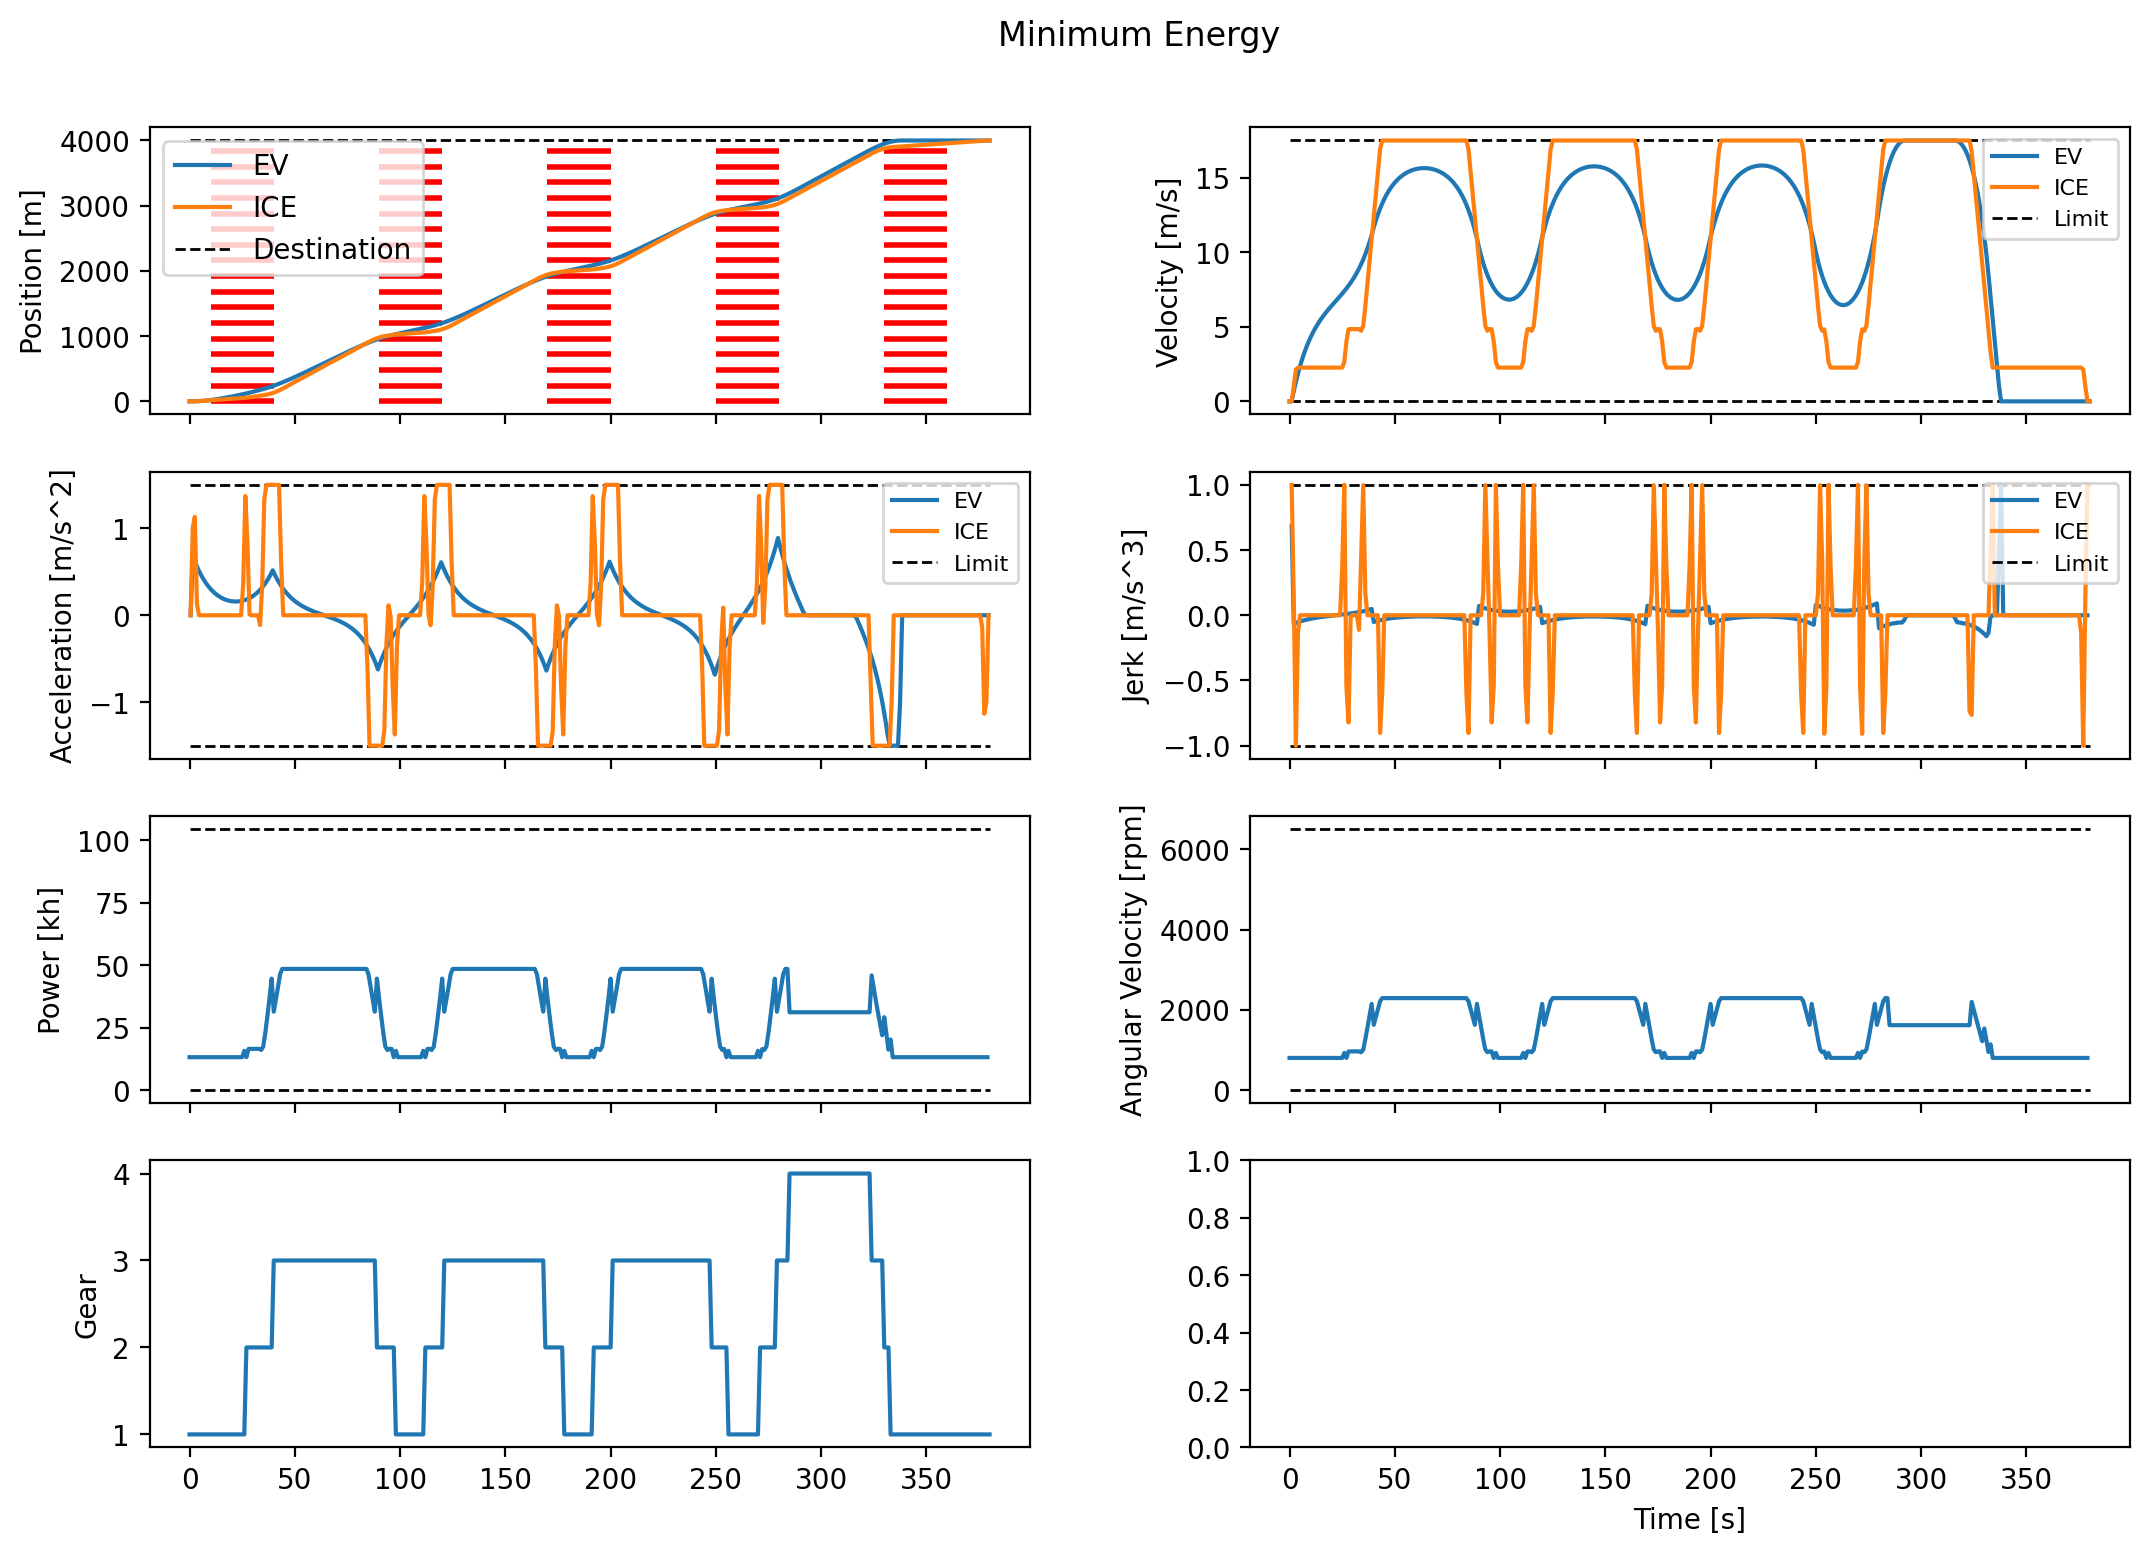

In [29]:
print(f"======{'='*len(title)}======")
print(f"===== {title} =====")
print(f"======{'='*len(title)}======")
print(f"Time of Travel = {np.where(x1.value>=pos_final-0.00001)[0][0]*dt:.0f} seconds")
print(f"Max Power = {np.max(Pe.value):.2f} kW")
print(f"Max Vel = {np.max((x2.value)):.4} m/s")
print(f"Max Acc = {np.max((x2.value[1:]-x2.value[:-1])/dt):.4} m/s^2")
print(f"Max Jerk = {np.max((x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2):.4} m/s^3")

time = np.arange(0, (N+1)*dt, dt)
fig, axs = plt.subplots(4,2, figsize=(12,8), sharex=True)
axs = axs.flatten()
legend_font = 8
fig.suptitle(title)

# Plot order
plt_pos = 0
plt_vel = 1
plt_acc = 2
plt_jerk = 3
plt_power = 4
plt_ang = 5
plt_gear = 6

axs[plt_pos].plot(time, x1.value, label='EV')
axs[plt_pos].plot(time, x1_ICE.value, label='ICE')
axs[plt_pos].set_ylabel('Position [m]')
for i in range(len(tls)):
    # Ensure that traffic light fits into optimization horizon
    if int(tls[i][plt_pos]/dt) <= N:
        axs[plt_pos].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

axs[plt_pos].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
axs[plt_pos].legend()
axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2.value[1:]-x2.value[:-1])/dt, label='EV')
axs[plt_acc].plot((time[1:]+time[:-1])/2, (x2_ICE.value[1:]-x2_ICE.value[:-1])/dt, label='ICE')
axs[plt_acc].hlines(y=-acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_acc].legend(loc='upper right', fontsize=legend_font)
axs[plt_acc].set_ylabel('Acceleration [m/s^2]')
axs[plt_vel].plot(time, x2.value, label='EV')
axs[plt_vel].plot(time, x2_ICE.value, label='ICE')
axs[plt_vel].hlines(y=vel_lower, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_vel].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_vel].legend(loc='upper right', fontsize=legend_font)
axs[plt_vel].set_ylabel('Velocity [m/s]')
axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2.value[2:]-2*x2.value[1:-1]+x2.value[:-2])/dt**2, label='EV')
axs[plt_jerk].plot((time[2:]+time[:-2])/2, (x2_ICE.value[2:]-2*x2_ICE.value[1:-1]+x2_ICE.value[:-2])/dt**2, label='ICE')
axs[plt_jerk].hlines(y=-jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_jerk].hlines(y=jerk_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_jerk].legend(loc='upper right', fontsize=legend_font)
axs[plt_jerk].set_ylabel('Jerk [m/s^3]')
axs[plt_power].plot(time[:-1], Pe.value)
axs[plt_power].hlines(y=0, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_power].hlines(y=P_max, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_power].set_ylabel('Power [kh]')
axs[plt_ang].plot(time[:-1], we.value)
axs[plt_ang].hlines(y=0, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Limit')
axs[plt_ang].hlines(y=wp_max, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1)
axs[plt_ang].set_ylabel('Angular Velocity [rpm]')
axs[plt_gear].plot(time, gears)
axs[plt_gear].set_ylabel('Gear')

axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
plt.show()

 ## Preliminary Parameter Study

In [ ]:
# parameter to alter
vel_upper_lst = [45, 40, 35, 30, 25]    # [mph]
acc_abs_lst = [1, 2, 3, 4, 5]           # [m/s^2]
redlight_lst = [60, 50, 40, 30, 20]     # [s]
jerk_lst = [1, 2, 3, 4, 5] # [m/s^3]
# Uncomment below for shorter test
# vel_upper_lst = [40, 45]
# acc_abs_lst = [1, 2]
# redlight_lst = [30, 40]
# jerk_lst = [1, 2]
# pos_final = 3500

### `set_up()`

In [ ]:
def set_up(vel_upper=vel_upper, acc_abs=acc_abs, redlight=redlight, jerk_abs=jerk_abs):
    
    
    # Define optimization vars

    x1 = cp.Variable(N+1) # Position
    x2 = cp.Variable(N+1) # Velocity
    T = cp.Variable(N) # Powertrain torque
    Fdrag = cp.Variable(N) # Vehicle drag
    E = cp.Variable(N+1) # Battery energy
    Pmot = cp.Variable(N) # Battery power
    Vcirc = cp.Variable(N) # Circuit voltage
    I = cp.Variable(N) # Motor current
    SOC = cp.Variable(N+1) # Battery SOC
    pedal = cp.Variable(N, integer=True)

    # Define objective function
    objective = cp.Minimize( E[0]-E[N] ); title = 'Minimum Energy' # Minimum energy
    # objective = cp.Minimize(-x1@np.ones(N+1) + (E[0]-E[N])); title = 'Minimum Time' # Minimum time - Lower N until solver fails for guaranteed minimum time

    # Define constraints
    constraints = [ ] 
    constraints += [ x1[0] == 0 ] # pos_init = 0 m
    constraints += [ x1[N] == pos_final ] # pos_final = 1000 m
    constraints += [ x2[0] == 0 ] # vel_init = 0 m/s
    constraints += [ x2[N] == 0 ] # vel_final = 0 m/s
    constraints += [ x2[1] == x2[0] ] # # acc_init = 0 m/s^2
    constraints += [ x2[N] == x2[N-1] ] # acc_final = 0 m/s^2
    
    # Traffic light constraints
    # Define a traffic light as [initial time, final time, position]

    tls = []
    for intersection in np.arange(0, pos_final, block):
        for start in np.arange(10, N*dt, redlight + greenlight):
            tls.append([start, start + redlight, intersection]) # + random.randint(-5, 5)

    tls_bools = {}
    tls_on = True # Control whether or not traffic lights are used
    # The for loop below will automatically create constraints for all traffic lights
    for i in range(len(tls)):
        # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N and tls_on:            
            dict_index = "tl{0}".format(i)
            tls_bools[dict_index] = cp.Variable(1, boolean=True)
            # Clip end of traffic light if it goes past optimization horizon
            t_initial = int(tls[i][0]/dt)
            if int(tls[i][1]/dt) > N:
                t_final = N
            else:
                t_final = int(tls[i][1]/dt)
            position = tls[i][2]
            constraints += [ x1[t_final]   - position <=  M*tls_bools[dict_index] ]
            constraints += [ x1[t_initial] - position >= -M*(1-tls_bools[dict_index]) ]

    for k in range(0,N):
        # vel_lower >= 0 m/s
        constraints += [ x2[k+1] >= vel_lower ]
        # vel_lower <= 15 m/s (~55 km/hr)
        constraints += [ x2[k+1] <= vel_upper ]
        # acc_lower >= -3 m/s^2
        constraints += [ (x2[k+1] - x2[k])/dt >= -acc_abs ]
        # acc_upper <= 3 m/s^2
        constraints += [ (x2[k+1] - x2[k])/dt <= acc_abs ]
        constraints += [ x1[k+1] == x1[k] + x2[k]*dt ]
        constraints += [ x2[k+1] == x2[k] + ( (T[k])/m/r*gear_ratio*dt_eff - Fdrag[k]/m)*dt ]
        constraints += [ Fdrag[k] >= 0.5*rho*Cd*Aref*x2[k]**2 + Cv*x2[k] + Crr*m*g*pedal[k] ]
        constraints += [ E[k+1] == E[k] - Voc*Vcirc[k]/Rcirc*dt/3600 ]
        constraints += [ x2[k]*60/(2*np.pi*r)*gear_ratio <= max_speed ]
        constraints += [ T[k] <= Tmax_Nm/(max_speed-Tmax_rpm)*max_speed + (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
        constraints += [ T[k] >= - Tmax_Nm/(max_speed-Tmax_rpm)*max_speed - (Tmax_Nm/-(max_speed-Tmax_rpm))*x2[k]*60/(2*np.pi*r)*gear_ratio ]
        constraints += [ x1[k] >= (pos_final)*(1-pedal[k]) ]
        
    # Pedal
    constraints += [ pedal <= 1]
    constraints += [ pedal >= 0]

    # SOC
    constraints += [ SOC[0] == 0.8 ]
    constraints += [ SOC == E/capacity_kWh/1000]
    constraints += [ SOC <= 0.8 ]
    constraints += [ SOC >= 0.2 ]
    # Power
    constraints += [ Pmot <= Vcirc/Rcirc*Voc - (Vcirc)**2/Rcirc ] # Relaxed SOC constraint --> Becomes tight to minimize energy loss
    constraints += [ T <= Tmax_Nm ]
    constraints += [ T >= -Tmax_Nm ]
    constraints += [ T == Pmot/(Pmax_kW*1000)*Tmax_Nm ]
    # Voc
    constraints += [ Vcirc/Rcirc <= (Pmax_kW*1000)/Voc ] # Current limit

    for k in range(1, N):
        # Minimize jerk (derivative of acceleration)
        constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 <= jerk_abs ]
        constraints += [ (x2[k+1] - 2*x2[k] + x2[k-1])/dt**2 >= -jerk_abs ]
    

    prob = cp.Problem(objective, constraints)
    prob.solve(solver='MOSEK')

    E_regen = np.zeros(N+1)
    for i in range(1, len(E_regen)):
        if Vcirc.value[i-1] < 0:
            E_regen[i] = E_regen[i-1] - Voc*Vcirc.value[i-1]/Rcirc*dt/3600
        else:
            E_regen[i] = E_regen[i-1]
            
    ext_range = [1/(SOC.value[0] - SOC.value[i])*pos_final/1609.34 for i in range(2, N+1)]
    
    var_dict = {
        
        'x1': x1.value,
        'x2': x2.value,
        'T': T.value,
        'Fdrag': Fdrag.value,
        'E': E.value,
        'Pmot': Pmot.value,
        'Vcirc': Vcirc.value,
        'I': I.value,
        'SOC': SOC.value,
        'regen': E_regen,
        'ext_range': ext_range
        
    }
    
    return objective, constraints, var_dict

### `optimizer_loop()`

In [ ]:
def optimizer_loop(vel_upper_lst=[vel_upper], acc_abs_lst=[acc_abs], redlight_lst=[redlight], jerk_lst=[jerk_abs]):
    
    pos = []
    vel = []
    soc = []
    regen = []
    ext_range = []
    
    tic_glob = time.perf_counter() 
    
    for vel_upper in vel_upper_lst:
        
        vel_upper_ms = vel_upper * 0.44704
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(vel_upper=vel_upper_ms)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        ext_range.append(var_dict['ext_range'])
        
        print(f"====== Solving with vel_upper = {vel_upper} mph : {toc - tic:0.3f} seconds ======")

    print("")
    for acc_abs in acc_abs_lst:
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(acc_abs=acc_abs)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        ext_range.append(var_dict['ext_range'])
        
        print(f"====== Solving with acc_abs = {acc_abs} m/s2 : {toc - tic:0.3f} seconds ========")
    
    print("")
    
    for jerk in jerk_lst:
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(jerk_abs=jerk)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        ext_range.append(var_dict['ext_range'])
    
        print(f"====== Solving with jerk_abs = {jerk} m/s^3 : {toc - tic:0.3f} seconds =======")
        
    print("")
    for redlight in redlight_lst:
        
        tic = time.perf_counter()
        objective, constraints, var_dict = set_up(redlight=redlight)
        toc = time.perf_counter()
        
        pos.append(var_dict['x1'])
        vel.append(var_dict['x2'])
        soc.append(var_dict['SOC'])
        regen.append(var_dict['regen'])
        ext_range.append(var_dict['ext_range'])
    
        print(f"====== Solving with redlight = {redlight} s : {toc - tic:0.3f} seconds =========")
        
    toc_glob = time.perf_counter()
    
    print("")
    print(f"Loop complete")
    print(f"Time used = : {toc_glob - tic_glob:0.3f} seconds")
    
    return pos, vel, soc, regen, ext_range

### Results assignment

In [ ]:
# Took 185s on my local machine, and it's taking ~300s on Colab

import time
pos_rst, vel_rst, soc_rst, regen_rst, ext_range_rst = optimizer_loop(vel_upper_lst=vel_upper_lst, 
                                                                     acc_abs_lst=acc_abs_lst,
                                                                     redlight_lst=redlight_lst,
                                                                     jerk_lst=jerk_lst)

====== Solving with vel_upper = 40 mph : 27.540 seconds ======
====== Solving with vel_upper = 45 mph : 39.254 seconds ======

====== Solving with acc_abs = 1 m/s2 : 27.181 seconds ========
====== Solving with acc_abs = 2 m/s2 : 27.311 seconds ========

====== Solving with jerk_abs = 1 m/s^3 : 25.733 seconds =======
====== Solving with jerk_abs = 2 m/s^3 : 27.621 seconds =======

====== Solving with redlight = 30 s : 26.737 seconds =========
====== Solving with redlight = 40 s : 22.143 seconds =========

Loop complete
Time used = : 223.524 seconds


### `param_plot_print()`

In [ ]:
def param_plot_print(time):
    
    fig, axs = plt.subplots(4, 5, figsize=(24, 12), sharex=True)
    legend_font = 8

    tls = []
    for intersection in np.arange(0, pos_final, block):
        for start in np.arange(10, N*dt, redlight + greenlight):
            tls.append([start, start + redlight, intersection])

    plt_soc = 0
    plt_acc = 1
    plt_x1 = 2
    plt_x2 = 3
    plt_range = 4


    row_vel = 0
    row_acc = 1
    row_jerk = 2
    row_red = 3

    # row 1: altering v_max ===================================================
    axs[row_vel][plt_soc].hlines(y=0.8, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$SOC_0$')
    axs[row_vel][plt_soc].plot(time, soc_rst[0], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_soc].plot(time, soc_rst[1], label=f'{vel_upper_lst[1]}')
    axs[row_vel][plt_soc].plot(time, soc_rst[2], label=f'{vel_upper_lst[2]}')
    axs[row_vel][plt_soc].plot(time, soc_rst[3], label=f'{vel_upper_lst[3]}')
    axs[row_vel][plt_soc].plot(time, soc_rst[4], label=f'{vel_upper_lst[4]}')
    axs[row_vel][plt_soc].set_ylabel('SOC [%]')
    axs[row_vel][plt_soc].legend(title=r'$v_{max}$ [mph]', loc='upper right', fontsize=legend_font)

    ax_twin = axs[row_vel][plt_soc].twinx()
    ax_twin.plot(time, regen_rst[0]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[1]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[2]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[3]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[4]/(capacity_kWh*1000))

    axs[row_vel][plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_vel][plt_acc].hlines(y=-1*acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[0][1:]-vel_rst[0][:-1])/dt, label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[1][1:]-vel_rst[1][:-1])/dt, label=f'{vel_upper_lst[1]}')
    axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[2][1:]-vel_rst[2][:-1])/dt, label=f'{vel_upper_lst[2]}')
    axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[3][1:]-vel_rst[3][:-1])/dt, label=f'{vel_upper_lst[3]}')
    axs[row_vel][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[4][1:]-vel_rst[4][:-1])/dt, label=f'{vel_upper_lst[4]}')
    axs[row_vel][plt_acc].set_ylabel('Acceleration [m/s^2]')
    axs[row_vel][plt_acc].legend(title=r'$v_{max}$ [mph]', loc='lower right', fontsize=legend_font)
    
    axs[row_vel][plt_x1].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
    axs[row_vel][plt_x1].plot(time, pos_rst[0], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_x1].plot(time, pos_rst[1], label=f'{vel_upper_lst[1]}')
    axs[row_vel][plt_x1].plot(time, pos_rst[2], label=f'{vel_upper_lst[2]}')
    axs[row_vel][plt_x1].plot(time, pos_rst[3], label=f'{vel_upper_lst[3]}')
    axs[row_vel][plt_x1].plot(time, pos_rst[4], label=f'{vel_upper_lst[4]}')
    axs[row_vel][plt_x1].set_ylabel('Pos [m]')
    axs[row_vel][plt_x1].legend(title=r'$v_{max}$ [mph]', loc='lower right', fontsize=legend_font)

    for i in range(len(tls)):
      # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N:
            axs[row_vel][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

    axs[row_vel][plt_x2].plot(time, vel_rst[0], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_x2].plot(time, vel_rst[1], label=f'{vel_upper_lst[1]}')
    axs[row_vel][plt_x2].plot(time, vel_rst[2], label=f'{vel_upper_lst[2]}')
    axs[row_vel][plt_x2].plot(time, vel_rst[3], label=f'{vel_upper_lst[3]}')
    axs[row_vel][plt_x2].plot(time, vel_rst[4], label=f'{vel_upper_lst[4]}')
    axs[row_vel][plt_x2].set_ylabel('Vel [m/s]')
    axs[row_vel][plt_x2].legend(title=r'$v_{max}$ [mph]', loc='upper right', fontsize=legend_font)
    
    
    axs[row_vel][plt_range].plot(time[102:], ext_range_rst[0][100:], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_range].plot(time[102:], ext_range_rst[1][100:], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_range].plot(time[102:], ext_range_rst[2][100:], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_range].plot(time[102:], ext_range_rst[3][100:], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_range].plot(time[102:], ext_range_rst[4][100:], label=f'{vel_upper_lst[0]}')
    axs[row_vel][plt_range].set_ylabel('Estimated Range [miles]')
    axs[row_vel][plt_range].legend(title=r'$v_{max}$ [mph]', loc='upper right', fontsize=legend_font)
    axs[row_vel][plt_range].hlines(y=full_range, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Full Range')

    # row 2: altering acc_max ================================================
    axs[row_acc][plt_soc].hlines(y=0.8, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$SOC_0$')
    axs[row_acc][plt_soc].plot(time, soc_rst[5], label=f'{acc_abs_lst[0]}')
    axs[row_acc][plt_soc].plot(time, soc_rst[6], label=f'{acc_abs_lst[1]}')
    axs[row_acc][plt_soc].plot(time, soc_rst[7], label=f'{acc_abs_lst[2]}')
    axs[row_acc][plt_soc].plot(time, soc_rst[8], label=f'{acc_abs_lst[3]}')
    axs[row_acc][plt_soc].plot(time, soc_rst[9], label=f'{acc_abs_lst[4]}')
    axs[row_acc][plt_soc].set_ylabel('SOC [%]')
    axs[row_acc][plt_soc].legend(title=r'$a_{max}$ [m/s^2]', loc='upper right', fontsize=legend_font)
    ax_twin = axs[row_acc][plt_soc].twinx()
    ax_twin.plot(time, regen_rst[5]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[6]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[7]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[8]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[9]/(capacity_kWh*1000))
    
    axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[5][1:]-vel_rst[5][:-1])/dt, label=f'{acc_abs_lst[0]}')
    axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[6][1:]-vel_rst[6][:-1])/dt, label=f'{acc_abs_lst[1]}')
    axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[7][1:]-vel_rst[7][:-1])/dt, label=f'{acc_abs_lst[2]}')
    axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[8][1:]-vel_rst[8][:-1])/dt, label=f'{acc_abs_lst[3]}')
    axs[row_acc][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[9][1:]-vel_rst[9][:-1])/dt, label=f'{acc_abs_lst[4]}')
    axs[row_acc][plt_acc].set_ylabel('Acceleration [m/s^2]')
    axs[row_acc][plt_acc].legend(title=r'$a_{max}$ [m/s^2]', loc='lower right', fontsize=legend_font)

    axs[row_acc][plt_x1].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
    axs[row_acc][plt_x1].plot(time, pos_rst[5], label=f'{acc_abs_lst[0]}')
    axs[row_acc][plt_x1].plot(time, pos_rst[6], label=f'{acc_abs_lst[1]}')
    axs[row_acc][plt_x1].plot(time, pos_rst[7], label=f'{acc_abs_lst[2]}')
    axs[row_acc][plt_x1].plot(time, pos_rst[8], label=f'{acc_abs_lst[3]}')
    axs[row_acc][plt_x1].plot(time, pos_rst[9], label=f'{acc_abs_lst[4]}')
    axs[row_acc][plt_x1].set_ylabel('Pos [m]')
    axs[row_acc][plt_x1].legend(title=r'$a_{max}$ [m/s^2]', loc='lower right', fontsize=legend_font)

    for i in range(len(tls)):
      # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N:
            axs[row_acc][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

    axs[row_acc][plt_x2].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$v_{max}$')
    axs[row_acc][plt_x2].plot(time, vel_rst[5], label=f'{acc_abs_lst[0]}')
    axs[row_acc][plt_x2].plot(time, vel_rst[6], label=f'{acc_abs_lst[1]}')
    axs[row_acc][plt_x2].plot(time, vel_rst[7], label=f'{acc_abs_lst[2]}')
    axs[row_acc][plt_x2].plot(time, vel_rst[8], label=f'{acc_abs_lst[3]}')
    axs[row_acc][plt_x2].plot(time, vel_rst[9], label=f'{acc_abs_lst[4]}')
    axs[row_acc][plt_x2].set_ylabel('Vel [m/s]')
    axs[row_acc][plt_x2].legend(title=r'$a_{max}$ [m/s^2]', loc='upper right', fontsize=legend_font)
    
    axs[row_acc][plt_range].plot(time[102:], ext_range_rst[5][100:], label=f'{acc_abs_lst[0]}')
    axs[row_acc][plt_range].plot(time[102:], ext_range_rst[6][100:], label=f'{acc_abs_lst[1]}')
    axs[row_acc][plt_range].plot(time[102:], ext_range_rst[7][100:], label=f'{acc_abs_lst[2]}')
    axs[row_acc][plt_range].plot(time[102:], ext_range_rst[8][100:], label=f'{acc_abs_lst[3]}')
    axs[row_acc][plt_range].plot(time[102:], ext_range_rst[9][100:], label=f'{acc_abs_lst[4]}')
    axs[row_acc][plt_range].set_ylabel('Estimated Range [miles]')
    axs[row_acc][plt_range].legend(title=r'$a_{max}$ [m/s^2]', loc='upper right', fontsize=legend_font)
    axs[row_acc][plt_range].hlines(y=full_range, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Full Range')

    # row 3: altering bound on jerk_abs ====================================
    axs[row_jerk][plt_soc].hlines(y=0.8, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$SOC_0$')
    axs[row_jerk][plt_soc].plot(time, soc_rst[10], label=f'{jerk_lst[0]}')
    axs[row_jerk][plt_soc].plot(time, soc_rst[11], label=f'{jerk_lst[1]}')
    axs[row_jerk][plt_soc].plot(time, soc_rst[12], label=f'{jerk_lst[2]}')
    axs[row_jerk][plt_soc].plot(time, soc_rst[13], label=f'{jerk_lst[3]}')
    axs[row_jerk][plt_soc].plot(time, soc_rst[14], label=f'{jerk_lst[4]}')
    axs[row_jerk][plt_soc].set_ylabel('SOC [%]')
    axs[row_jerk][plt_soc].legend(title=r'$jerk_{max}$ [m/s^3]', loc='upper right', fontsize=legend_font)
    axs[row_jerk][plt_soc].set_xlabel('Time [s]')
    ax_twin = axs[row_jerk][plt_soc].twinx()
    ax_twin.plot(time, regen_rst[10]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[11]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[12]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[13]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[14]/(capacity_kWh*1000))

    axs[row_jerk][plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_jerk][plt_acc].hlines(y=-1*acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_jerk][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[10][1:]-vel_rst[10][:-1])/dt, label=f'{jerk_lst[0]}')
    axs[row_jerk][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[11][1:]-vel_rst[11][:-1])/dt, label=f'{jerk_lst[1]}')
    axs[row_jerk][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[12][1:]-vel_rst[12][:-1])/dt, label=f'{jerk_lst[2]}')
    axs[row_jerk][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[13][1:]-vel_rst[13][:-1])/dt, label=f'{jerk_lst[3]}')
    axs[row_jerk][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[14][1:]-vel_rst[14][:-1])/dt, label=f'{jerk_lst[4]}')
    axs[row_jerk][plt_acc].set_ylabel('Acceleration [m/s^2]')
    axs[row_jerk][plt_acc].legend(title=r'$jerk_{max}$ [m/s^3]', loc='lower right', fontsize=legend_font)
    axs[row_jerk][plt_acc].set_xlabel('Time [s]')

    axs[row_jerk][plt_x1].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
    axs[row_jerk][plt_x1].plot(time, pos_rst[10], label=f'{jerk_lst[0]}')
    axs[row_jerk][plt_x1].plot(time, pos_rst[11], label=f'{jerk_lst[1]}')
    axs[row_jerk][plt_x1].plot(time, pos_rst[12], label=f'{jerk_lst[2]}')
    axs[row_jerk][plt_x1].plot(time, pos_rst[13], label=f'{jerk_lst[3]}')
    axs[row_jerk][plt_x1].plot(time, pos_rst[14], label=f'{jerk_lst[4]}')
    axs[row_jerk][plt_x1].set_ylabel('Pos [m]')
    axs[row_jerk][plt_x1].legend(title=r'$jerk_{max}$ [m/s^3]', loc='lower right', fontsize=legend_font)
    axs[row_jerk][plt_x1].set_xlabel('Time [s]')

    for i in range(len(tls)):
      # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N:
            axs[row_jerk][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

    axs[row_jerk][plt_x2].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$v_{max}$')
    axs[row_jerk][plt_x2].plot(time, vel_rst[10], label=f'{jerk_lst[0]}')
    axs[row_jerk][plt_x2].plot(time, vel_rst[11], label=f'{jerk_lst[1]}')
    axs[row_jerk][plt_x2].plot(time, vel_rst[12], label=f'{jerk_lst[2]}')
    axs[row_jerk][plt_x2].plot(time, vel_rst[13], label=f'{jerk_lst[3]}')
    axs[row_jerk][plt_x2].plot(time, vel_rst[14], label=f'{jerk_lst[4]}')
    axs[row_jerk][plt_x2].set_ylabel('Vel [m/s]')
    axs[row_jerk][plt_x2].legend(title=r'$jerk_{max}$ [m/s^3]', loc='upper right', fontsize=legend_font)
    axs[row_jerk][plt_x2].set_xlabel('Time [s]')
    
    
    axs[row_jerk][plt_range].plot(time[102:], ext_range_rst[10][100:], label=f'{jerk_lst[0]}')
    axs[row_jerk][plt_range].plot(time[102:], ext_range_rst[11][100:], label=f'{jerk_lst[1]}')
    axs[row_jerk][plt_range].plot(time[102:], ext_range_rst[12][100:], label=f'{jerk_lst[2]}')
    axs[row_jerk][plt_range].plot(time[102:], ext_range_rst[13][100:], label=f'{jerk_lst[3]}')
    axs[row_jerk][plt_range].plot(time[102:], ext_range_rst[14][100:], label=f'{jerk_lst[4]}')
    axs[row_jerk][plt_range].set_ylabel('Estimated Range [miles]')
    axs[row_jerk][plt_range].legend(title=r'$jerk_{max}$ [m/s^3]', loc='upper right', fontsize=legend_font)
    axs[row_jerk][plt_range].hlines(y=full_range, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Full Range')
    
    # row 4: altering red_light duration ====================================
    axs[row_red][plt_soc].hlines(y=0.8, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$SOC_0$')
    axs[row_red][plt_soc].plot(time, soc_rst[15], label=f'{redlight_lst[0]}')
    axs[row_red][plt_soc].plot(time, soc_rst[16], label=f'{redlight_lst[1]}')
    axs[row_red][plt_soc].plot(time, soc_rst[17], label=f'{redlight_lst[2]}')
    axs[row_red][plt_soc].plot(time, soc_rst[18], label=f'{redlight_lst[3]}')
    axs[row_red][plt_soc].plot(time, soc_rst[19], label=f'{redlight_lst[4]}')
    axs[row_red][plt_soc].set_ylabel('SOC [%]')
    axs[row_red][plt_soc].legend(title=r'Red Duration [s]', loc='upper right', fontsize=legend_font)
    axs[row_red][plt_soc].set_xlabel('Time [s]')
    ax_twin = axs[row_red][plt_soc].twinx()
    ax_twin.plot(time, regen_rst[15]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[16]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[17]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[18]/(capacity_kWh*1000))
    ax_twin.plot(time, regen_rst[19]/(capacity_kWh*1000))

    axs[row_red][plt_acc].hlines(y=acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_red][plt_acc].hlines(y=-1*acc_abs, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$acc_{max}$')
    axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[15][1:]-vel_rst[15][:-1])/dt, label=f'{redlight_lst[0]}')
    axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[16][1:]-vel_rst[16][:-1])/dt, label=f'{redlight_lst[1]}')
    axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[17][1:]-vel_rst[17][:-1])/dt, label=f'{redlight_lst[2]}')
    axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[18][1:]-vel_rst[18][:-1])/dt, label=f'{redlight_lst[3]}')
    axs[row_red][plt_acc].plot((time[1:]+time[:-1])/2, (vel_rst[19][1:]-vel_rst[19][:-1])/dt, label=f'{redlight_lst[4]}')
    axs[row_red][plt_acc].set_ylabel('Acceleration [m/s^2]')
    axs[row_red][plt_acc].legend(title=r'Red Duration [s]', loc='lower right', fontsize=legend_font)
    axs[row_red][plt_acc].set_xlabel('Time [s]')

    axs[row_red][plt_x1].hlines(y=pos_final, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Destination')
    axs[row_red][plt_x1].plot(time, pos_rst[15], label=f'{redlight_lst[0]}')
    axs[row_red][plt_x1].plot(time, pos_rst[16], label=f'{redlight_lst[1]}')
    axs[row_red][plt_x1].plot(time, pos_rst[17], label=f'{redlight_lst[2]}')
    axs[row_red][plt_x1].plot(time, pos_rst[18], label=f'{redlight_lst[3]}')
    axs[row_red][plt_x1].plot(time, pos_rst[19], label=f'{redlight_lst[4]}')
    axs[row_red][plt_x1].set_ylabel('Pos [m]')
    axs[row_red][plt_x1].legend(title=r'Red Duration [s]', loc='lower right', fontsize=legend_font)
    axs[row_red][plt_x1].set_xlabel('Time [s]')

    for i in range(len(tls)):
      # Ensure that traffic light fits into optimization horizon
        if int(tls[i][0]/dt) <= N:
            axs[row_acc][plt_x1].hlines(y=tls[i][2], xmin=tls[i][0], xmax=tls[i][1], linewidth=2, color='r')

    axs[row_red][plt_x2].hlines(y=vel_upper, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label=r'$v_{max}$')
    axs[row_red][plt_x2].plot(time, vel_rst[15], label=f'{redlight_lst[0]}')
    axs[row_red][plt_x2].plot(time, vel_rst[16], label=f'{redlight_lst[1]}')
    axs[row_red][plt_x2].plot(time, vel_rst[17], label=f'{redlight_lst[2]}')
    axs[row_red][plt_x2].plot(time, vel_rst[18], label=f'{redlight_lst[3]}')
    axs[row_red][plt_x2].plot(time, vel_rst[19], label=f'{redlight_lst[4]}')
    axs[row_red][plt_x2].set_ylabel('Vel [m/s]')
    axs[row_red][plt_x2].legend(title=r'Red Duration [s]', loc='upper right', fontsize=legend_font)
    axs[row_red][plt_x2].set_xlabel('Time [s]')
    
    axs[row_red][plt_range].hlines(y=full_range, xmin=0, xmax=int(N*dt), color='k', linestyle='--', linewidth=1, label='Full Range')
    axs[row_red][plt_range].plot(time[102:], ext_range_rst[15][100:], label=f'{redlight_lst[0]}')
    axs[row_red][plt_range].plot(time[102:], ext_range_rst[16][100:], label=f'{redlight_lst[1]}')
    axs[row_red][plt_range].plot(time[102:], ext_range_rst[17][100:], label=f'{redlight_lst[2]}')
    axs[row_red][plt_range].plot(time[102:], ext_range_rst[18][100:], label=f'{redlight_lst[3]}')
    axs[row_red][plt_range].plot(time[102:], ext_range_rst[19][100:], label=f'{redlight_lst[4]}')
    axs[row_red][plt_range].set_ylabel('Estimated Range [miles]')
    axs[row_red][plt_range].legend(title=r'Red Duration [s]', loc='upper right', fontsize=legend_font)
                                    
    plt.tight_layout()
    # plt.subplots_adjust(left  = 0.0875, right = 0.9125, bottom = 0.0875, top = 0.9125, wspace = 0.25, hspace = 0.2)
    plt.show()

### Plots

IndexError: ignored

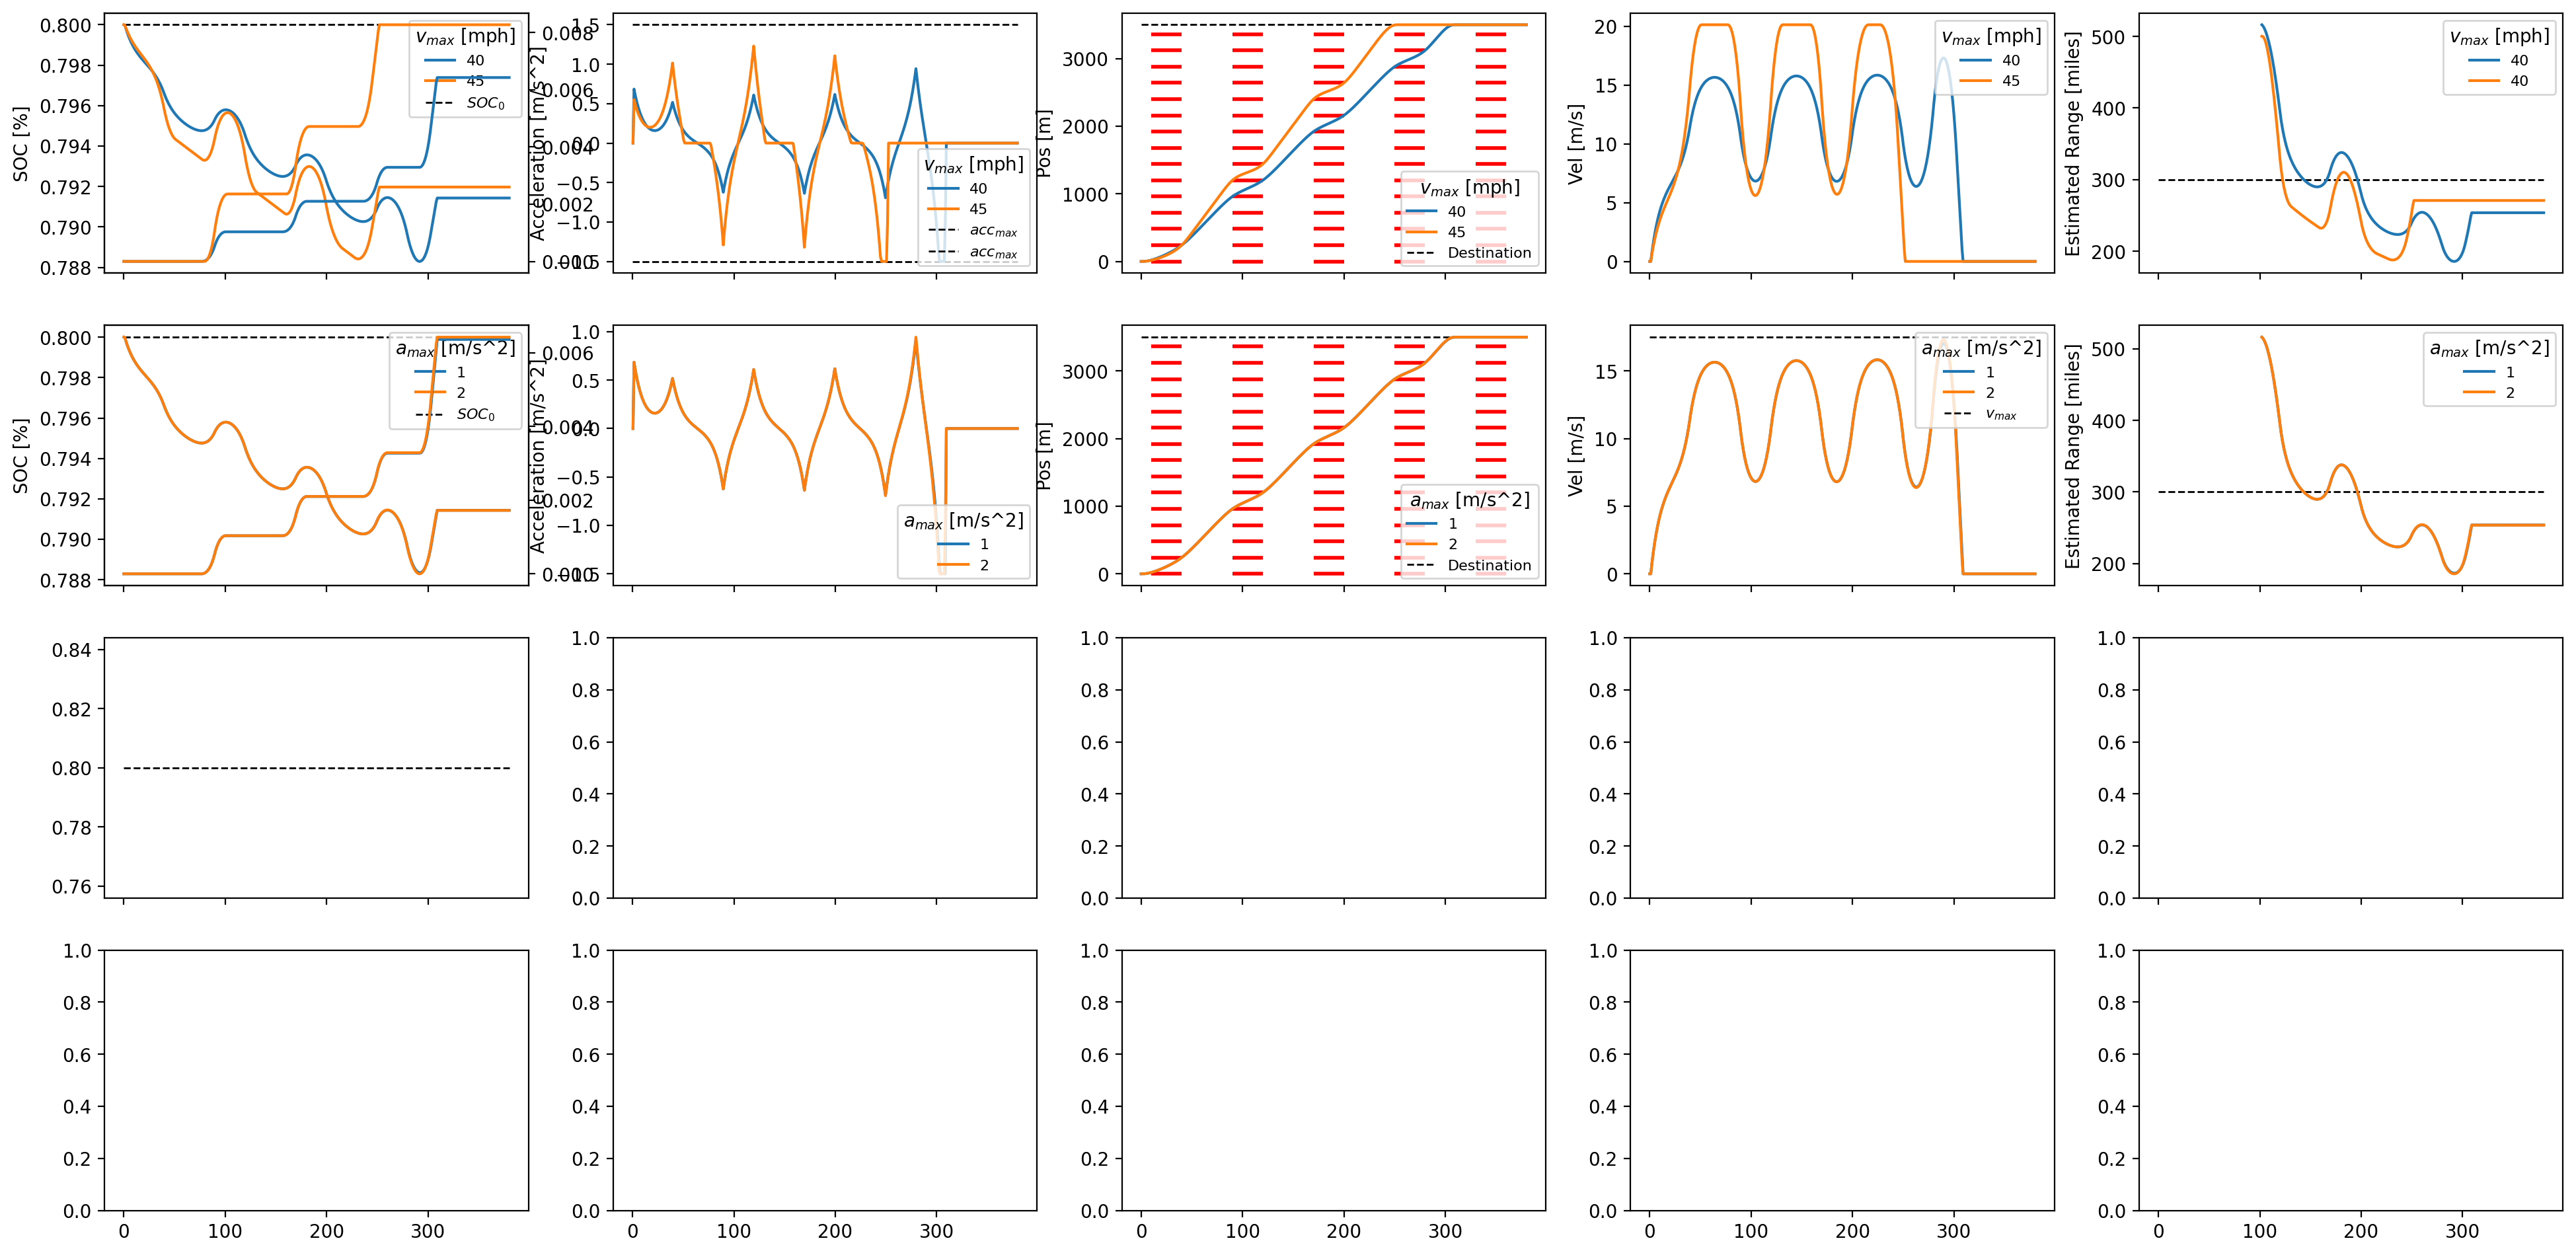

In [ ]:
time = np.arange(0, (N+1)*dt, dt)
param_plot_print(time)

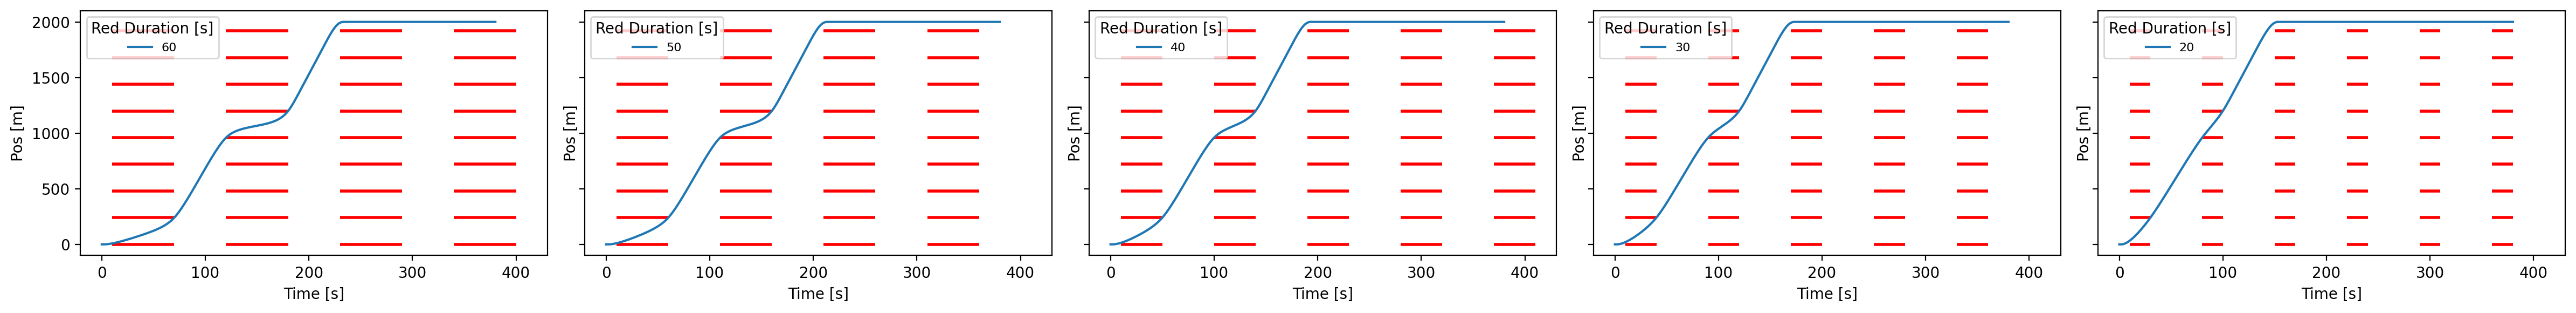

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(24, 3), sharex=True, sharey=True)

for i in np.arange(5):
    pos_index = 15 + i
    
    redlight = redlight_lst[i]
    
    axs[i].plot(time, pos_rst[pos_index], label=f'{redlight_lst[i]}')
    axs[i].set_ylabel('Pos [m]')
    axs[i].legend(title=r'Red Duration [s]', loc='upper left', fontsize=legend_font)
    axs[i].set_xlabel('Time [s]')
    
    tls = []
    for intersection in np.arange(0, pos_final, block):
        for start in np.arange(10, N*dt, redlight + greenlight):
            tls.append([start, start + redlight, intersection])
            
    for j in range(len(tls)):
        if int(tls[j][0]/dt) <= N:
            axs[i].hlines(y=tls[j][2], xmin=tls[j][0], xmax=tls[j][1], linewidth=2, color='r')
    
plt.tight_layout()
plt.show()

# 2. Platoon Optimization Formulation

### Assumptions for the Vehicle Platoon

1. one single lane, no merging and overtaking
2. fixed signal
3. when entering corridor, all CAV have same initial state, same spacing between, and same initial speed
4. straight line movements, no turning is considered

### Methods

- PTO (platoon-trajectory-optimization): trajectory copying the leading CAV with delay and min. gap defined 
- LACC



In [ ]:
N = 6             # Number of CAV in one platoon
tau = 0.1         # reaction time of each CAV [s]
l = d + v_0*tau   # initial space between two CAV [m]


NameError: ignored